In [90]:
import torch
import lightning
from minicons import cwe
import pandas as pd

from model import FFNModule, FeatureNormPredictor, FFNParams, TrainingParams

In [104]:
def get_file_name(model, layer):
    if model=='albert':
        return 'albert{}_to_binder_opt_stop'.format(layer)
    elif model=='bert':
        return 'bert_to_binder_stop_opt_layer{}'.format(layer),

In [91]:
albert_models = [FeatureNormPredictor.load_from_checkpoint(
    checkpoint_path='saved_models/comps/albert{}_to_binder_opt_stop.ckpt'.format(i),
    map_location=None
    ) for i in range(0,13)] # fill this out once we actually have the models

for model in albert_models:
    model.eval()
albert_lm = cwe.CWE('albert-xxlarge-v2')

albert_rob_emb = [albert_lm.extract_representation(("A wug is a robin", "robin"), layer=i) for i in range(0,13)]
albert_wug_emb = [albert_lm.extract_representation(("A wug is a robin", "wug"), layer=i) for i in range(0,13)]

In [93]:
bert_models = [FeatureNormPredictor.load_from_checkpoint(
    checkpoint_path='saved_models/comps_but_better/bert_to_binder_stop_opt_layer{}.ckpt'.format(i),
    map_location=None
    ) for i in range(0,13)] # fill this out once we actually have the models
for model in bert_models:
    model.eval()
bert_lm = cwe.CWE('bert-base-uncased')

bert_rob_emb = [bert_lm.extract_representation(("A wug is a robin", "robin"), layer=i) for i in range(0,13)]
bert_wug_emb = [bert_lm.extract_representation(("A wug is a robin", "wug"), layer=i) for i in range(0,13)]

In [ ]:
electra_models = [FeatureNormPredictor.load_from_checkpoint(
    checkpoint_path='saved_models/comps/electra_to_binder_layer{}.ckpt'.format(i),
    map_location=None
    ) for i in range(0,13)] # fill this out once we actually have the models
for model in electra_models:
    model.eval()
electra_lm = cwe.CWE('google/electra-base-discriminator')

electra_rob_emb = [electra_lm.extract_representation(("A wug is a robin", "robin"), layer=i) for i in range(0,13)]
electra_wug_emb = [electra_lm.extract_representation(("A wug is a robin", "wug"), layer=i) for i in range(0,13)]

In [107]:
lm = albert_lm
model = albert_models[8]
print(" hyperparams: ")
print("    ",model.ffn_params)
print("    ",model.training_params)

 hyperparams: 
     input_size=4096 output_size=65 hidden_size=84 num_layers=2 dropout=0.1
     num_epochs=60 batch_size=106 learning_rate=0.000629166429815455 weight_decay=0.0


In [108]:
with torch_no_grad():
    rob_emb = albert_rob_emb[8]
    rob_pred = torch.nn.functional.relu(model(rob_emb))
    rob_pred = rob_pred.squeeze(0)
    wug_emb = albert_wug_emb[8]
    wug_pred = torch.nn.functional.relu(model(wug_emb))
    wug_pred = wug_pred.squeeze(0)


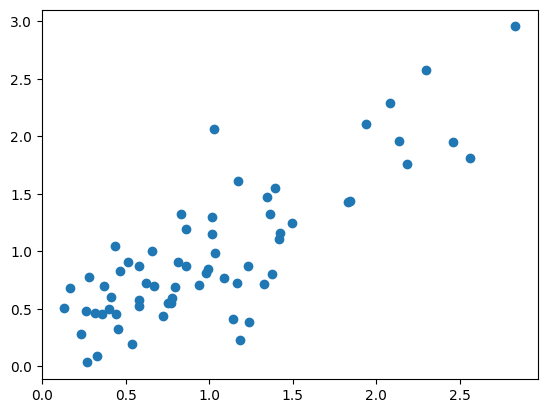

In [109]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(rob_pred.detach().numpy(), wug_pred.detach().numpy())
plt.show()

In [110]:
wug_reg_emb = lm.extract_representation(("A wug", "wug"))
with torch.no_grad(): wug_reg_pred = torch.nn.functional.relu(model(wug_reg_emb))
wug_reg_pred = wug_reg_pred.squeeze(0)

In [111]:
wug_anti_emb = lm.extract_representation(("A wug is not a robin", "wug"))
with torch.no_grad(): wug_anti_pred = torch.nn.functional.relu(model(wug_anti_emb))
wug_anti_pred = wug_anti_pred.squeeze(0)

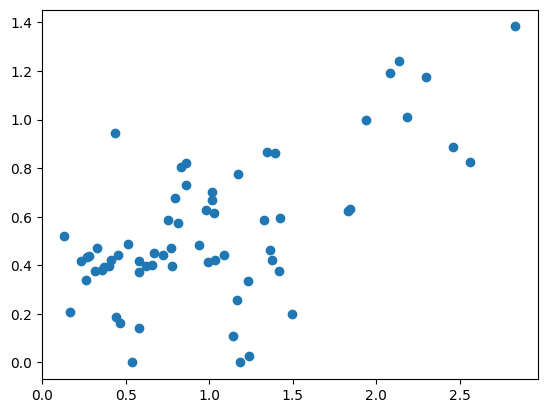

In [112]:
plt.figure()
plt.scatter(rob_pred.detach().numpy(), wug_reg_pred.detach().numpy())
plt.show()

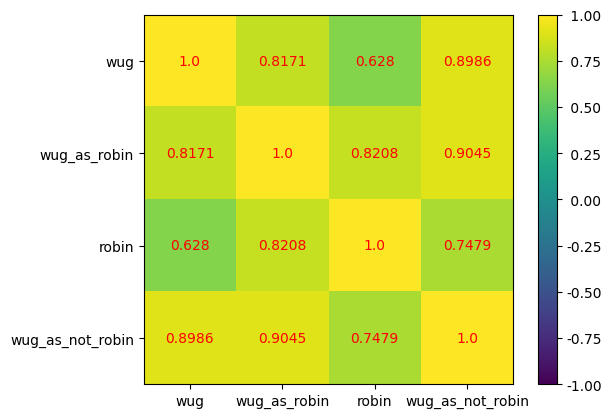

In [113]:
import numpy as np

all4 = np.array((wug_reg_pred.detach().numpy(), wug_pred.detach().numpy(), rob_pred.detach().numpy(), wug_anti_pred.detach().numpy()))

corr_matrix = np.corrcoef(all4).round(decimals=4)

fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3), ticklabels=('wug', 'wug_as_robin', 'robin', 'wug_as_not_robin'))
ax.yaxis.set(ticks=(0, 1, 2, 3), ticklabels=('wug', 'wug_as_robin', 'robin', 'wug_as_not_robin'))
ax.set_ylim(3.5, -0.5)
for i in range(4):
    for j in range(4):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.savefig('results/comps/'+get_file_name('albert',8).split('/')[-1]+'_wug_robin.png')

[0.7961007730151596, 0.6875331560921808, 0.9166925650184505, 0.8845101578065997, 0.8049044867304824, 0.8373972946667709, 0.8280397103112348, 0.7553282184891431, 0.8207597968196337, 0.7806313756623623, 0.8029440506442855, 0.803615880865041, 0.9184277139827071]
most correlated layer:  12


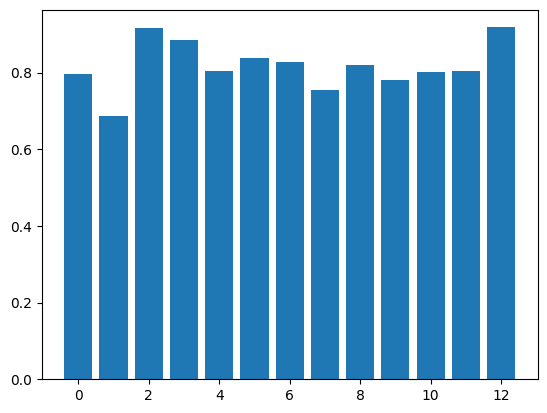

In [106]:
models = albert_models
lm = albert_lm
rob_emb = albert_rob_emb
wug_emb = albert_wug_emb

rs  =[]
for i in range(0,13):
    with torch.no_grad(): 
        model=models[i]
        rob_pred = torch.nn.functional.relu(model(rob_emb[i]))
        rob_pred = rob_pred.squeeze(0)
        wug_pred = torch.nn.functional.relu(model(wug_emb[i]))
        wug_pred = wug_pred.squeeze(0)
    r = np.corrcoef(rob_pred.detach().numpy(), wug_pred.detach().numpy())
    rs.append(r[0,1])

most = np.argmax(np.array(rs))
print(rs)
print("most correlated layer: ", most)

plt.figure()
plt.bar(np.arange(0,13),rs)
plt.savefig('results/comps/albert_corr_per_layer.png')

In [ ]:
dir(bert_models[0])

In [76]:
model0 = FeatureNormPredictor.load_from_checkpoint(
    checkpoint_path='saved_models/chronis_et_al/bert_to_binder_layer8_stopped_opt.ckpt'.format(i),
    map_location=None
    )
model0.eval()
model1 = FeatureNormPredictor.load_from_checkpoint(
    checkpoint_path='saved_models/comps_but_better/bert_to_binder_stop_opt_layer8.ckpt'.format(i),
    map_location=None
    )
model1.eval()
pred0=model0(bert_wug_emb[8]).detach().numpy()
pred1=model1(bert_wug_emb[8]).detach().numpy()

r_same=np.corrcoef(pred0,pred1)
r_same

array([[1., 1.],
       [1., 1.]])

In [77]:
print("0 hyperparams: ")
print("    ",model0.ffn_params)
print("    ",model0.training_params)
print("1 hyperparams: ")
print("    ",model1.ffn_params)
print("    ",model1.training_params)

0 hyperparams: 
     input_size=768 output_size=65 hidden_size=108 num_layers=2 dropout=0.1
     num_epochs=100 batch_size=29 learning_rate=0.0009698669239288068 weight_decay=0.0
1 hyperparams: 
     input_size=768 output_size=65 hidden_size=108 num_layers=2 dropout=0.1
     num_epochs=100 batch_size=29 learning_rate=0.0009698669239288068 weight_decay=0.0


In [117]:
labels = "These are some fake features".split(" ")
vals = np.random.randint(-10,10,(5))
print("heyo \n"+"\n".join([labels[i]+" "+str(vals[i]) for i in range(len(labels)) if vals[i]>0]))

heyo 
These 8
are 8
some 2
